# Predicting heart disease using Machine Learning.

## Introduction

Cardiovascular diseases are a leading cause of morbidity and mortality worldwide. Timely identification and prediction of heart diseases can significantly improve patient outcomes. In this notebook, we will explore the development of a machine learning model to predict the likelihood of a patient having heart disease based on a set of health-related features.

## Problem definition

Predicting the likelihood of patients having a heart disease based on a set of clinical features.

## Required libraries

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

- **NumPy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **scikit-learn**: The essential Machine Learning package in Python.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **Seaborn**: Advanced statistical plotting library.

## Data and data dictionnary

we will be using the [Cardiovascular disease Kaggle dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data)

Complete attribute documentation:

- age: age in years
- sex: sex (1 = male; 0 = female)
- cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
- restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- target: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)

## Goal

The primary objective is to create a robust machine learning model that can analyze the provided dataset and make accurate predictions about the presence or absence of heart disease. We will go through the following steps:

1. EDA: Understand the structure and characteristics of the dataset.
2. Data Preprocessing: Clean and prepare the data for training.
3. Feature Engineering: Identify key features that influence heart disease prediction.
4. Model Selection: Choose a suitable machine learning algorithm for classification.
5. Model Training: Train the selected model on the dataset.
6. Model Evaluation: Assess the performance of the model using appropriate metrics.
7. Hyperparameter Tuning: Optimize the model parameters for better accuracy.
8. Prediction: Make predictions on new data using the trained model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle

%matplotlib inline

In [2]:
df = pd.read_csv("../data/heart_disease.csv")

## 1- Exploratory Data Analysis

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.594059,0.676568,3.108911,131.785479,246.547855,0.148515,0.990099,149.194719,0.326733,1.057756,1.590759,0.683168,0.273927
std,9.016370,0.468560,1.028414,17.748338,52.175933,0.356198,0.988293,23.173368,0.469794,1.165025,0.617767,0.937773,0.446710
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


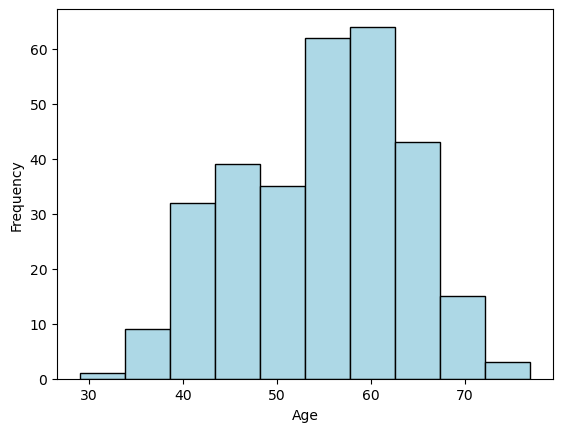

In [6]:
plt.hist(df['age'], color="lightblue", edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency');

the distribution of the age variable looks like a quasi-normal distribution.
let's verify it using the Shapiro-Wilk test for a threshhold of 5% 

In [7]:
stats.shapiro(df.age)

ShapiroResult(statistic=0.9856191277503967, pvalue=0.004022137261927128)

we got a pvalue equal to 0.4% which is signficantly smaller than 5%
age is not normally distributed 
let's check quasi-normality

In [8]:
df.age.skew(), df.age.kurt()

(-0.2274479934315017, -0.5090180686747039)

- the kurtosis and skewness of the age variable are both between -3 and 3. we can conclude that it's quasi-normal.

- The assumption of normality is often associated with statistical tests and models that rely on the normal distribution, such as t-tests or linear regression. However, many machine learning algorithms, especially those based on decision trees, ensemble methods, or neural networks, are less sensitive to the distribution of the input features. In such cases, the normal distribution assumption is not strictly necessary.
for that reason we can carry on our EDA without caring much about the normality of our data.

In [9]:
df.age.describe()

count    303.000000
mean      54.594059
std        9.016370
min       29.000000
25%       48.000000
50%       56.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

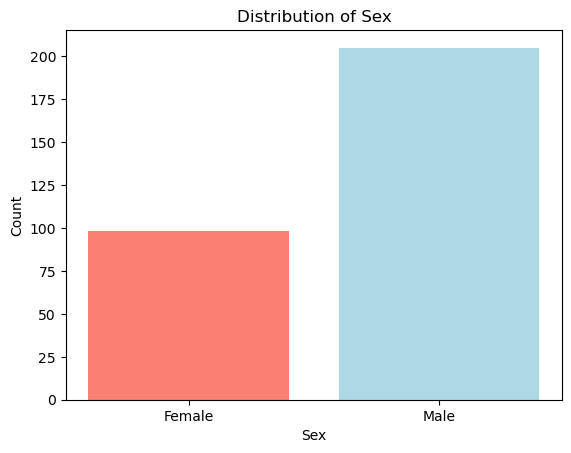

In [10]:
counts = df.sex.value_counts()
plt.bar(counts.index, counts.values, color=['lightblue', 'salmon'])
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex')
plt.xticks([0, 1], ['Female', 'Male']);

**Heads-up** : Clearly the dataset in our hands is not balanced in terms of sex. This can cause the models to be biased towards the majority class (Male in this case), and perform poorly on the minority class.
This is a point to be taken into consideration when we are evaluating our models.

In [11]:
df.thal.describe()

count        303
unique         5
top       normal
freq         168
Name: thal, dtype: object

In [12]:
df.thal.unique()

array(['fixed', 'normal', 'reversible', '1', '2'], dtype=object)

In [13]:
df.thal.value_counts()

thal
normal        168
reversible    115
fixed          18
1               1
2               1
Name: count, dtype: int64

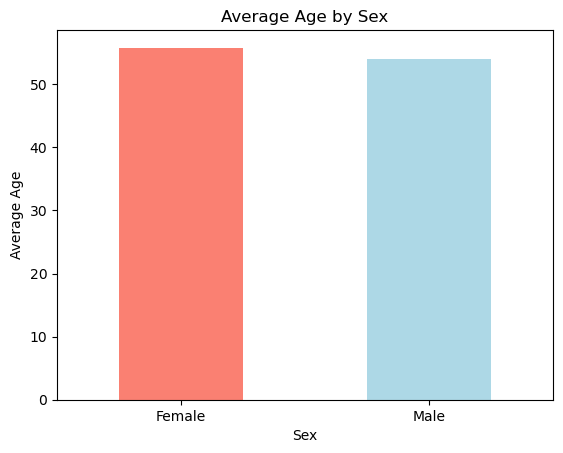

In [14]:
age_means = df.groupby('sex')['age'].mean()

age_means.plot(kind='bar', color=['salmon', 'lightblue'])

plt.xlabel('Sex')
plt.ylabel('Average Age')
plt.title('Average Age by Sex')
plt.xticks([0, 1], ['Female', 'Male'], rotation=0);

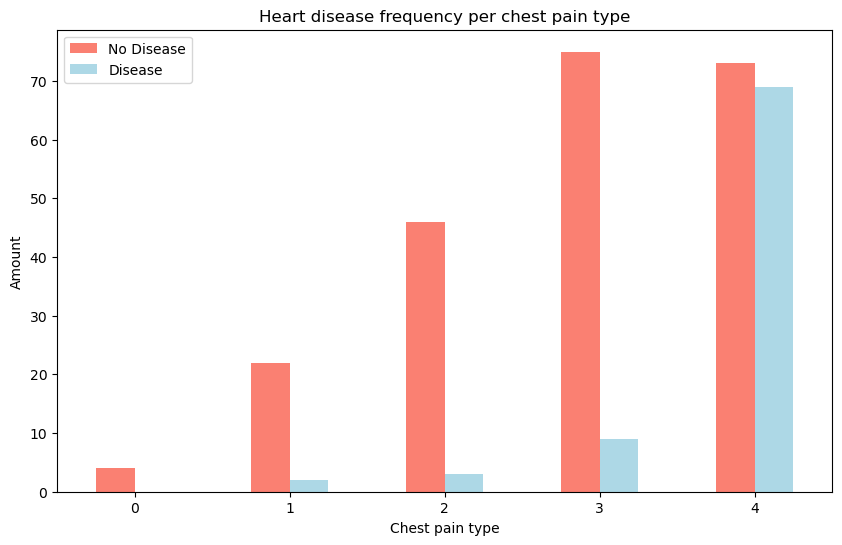

In [15]:
pd.crosstab(df.cp, df.target).plot(kind="bar",
                                   figsize=(10,6),
                                   color=["salmon", "lightblue"])
plt.title("Heart disease frequency per chest pain type")
plt.xlabel("Chest pain type")
plt.ylabel("Amount")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation=0);

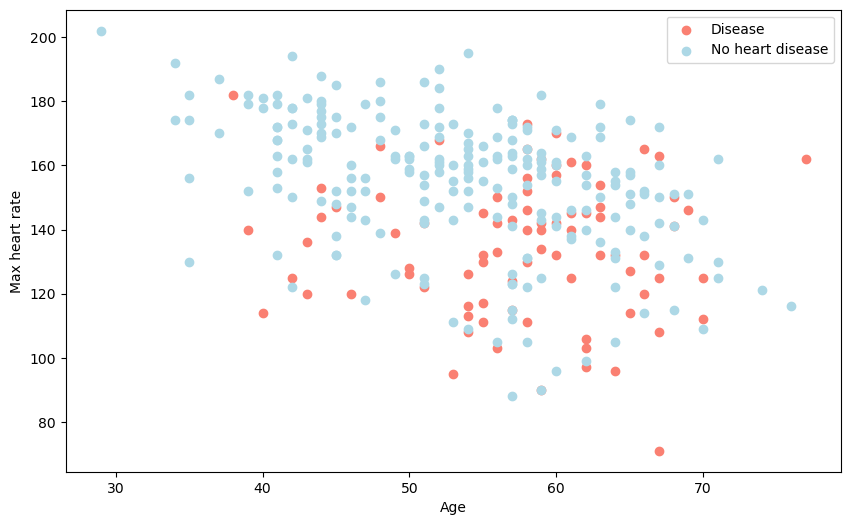

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c="salmon")

plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c="lightblue");
plt.xlabel("Age")
plt.ylabel("Max heart rate")
plt.legend(["Disease", "No heart disease"]);

### Let's check if there is any outliers in our data.

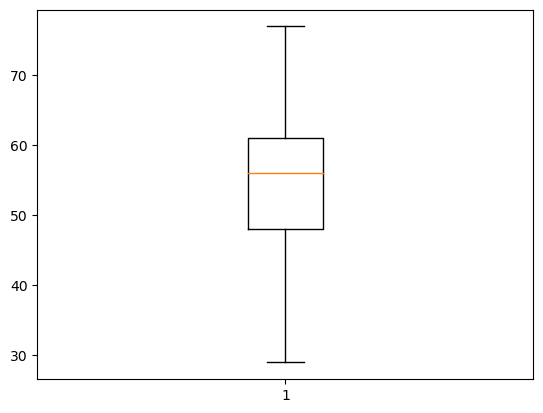

In [17]:
# handling outliers 
plt.boxplot(df.age);

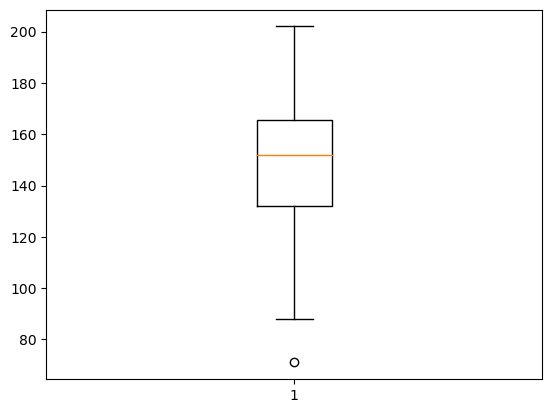

In [18]:
plt.boxplot(df.thalach);

In [19]:
def handleOutliers(column, df, method='iqr', threshhold=0.05):
    df.reset_index(drop=True, inplace=True)
    
    if method == 'iqr':
        Q1 = np.percentile(df[column], 25, method='midpoint')
        Q3 = np.percentile(df[column], 75, method='midpoint')
        IQR = Q3 - Q1
        Q1, Q3, IQR
        upper_bound = Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5*IQR

        outliers = (df[column] > upper_bound) | (df[column] < lower_bound)
        outliers_index = []

        for i in range(len(outliers)):
            if outliers[i] == True:
                outliers_index.append(i)
        mean = df[column][~outliers].mean()

        if len(outliers_index) < threshhold*len(df[column]):
            df.drop(outliers_index, inplace=True)
        else:
            for i in outliers_index:
                df.iloc[i] = mean
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(df[column]))
        
        outliers = z_scores > 3
        
        outliers_index = np.where(z_scores > 3)[0]

        mean = df[column][~outliers].mean()
        if len(outliers_index) < threshhold * len(df[column]):
            df.drop(outliers_index, inplace=True)
        else:
            for i in outliers_index:
                df.iloc[i] = mean


In [20]:
handleOutliers('thalach', df)

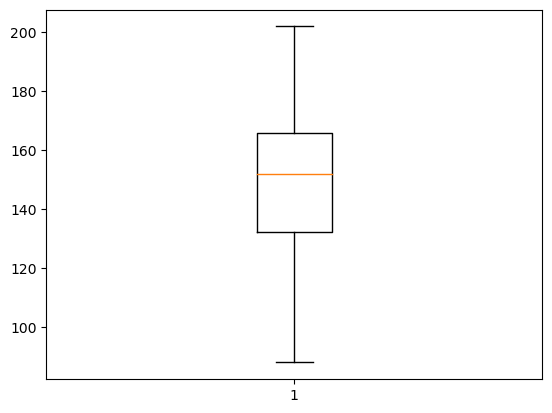

In [21]:
plt.boxplot(df.thalach);

In [22]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed,0
299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible,1
300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible,1
301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible,1


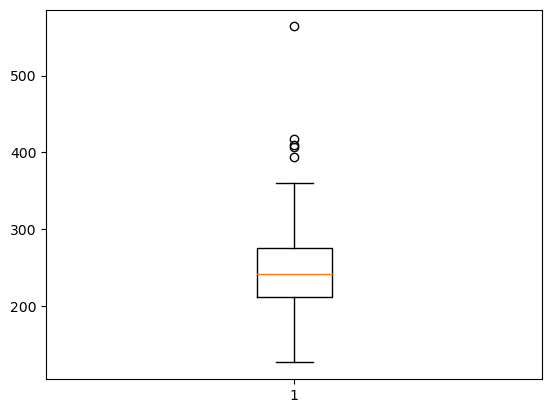

In [23]:
plt.boxplot(df.chol);

In [24]:
handleOutliers('chol', df, 'zscore')

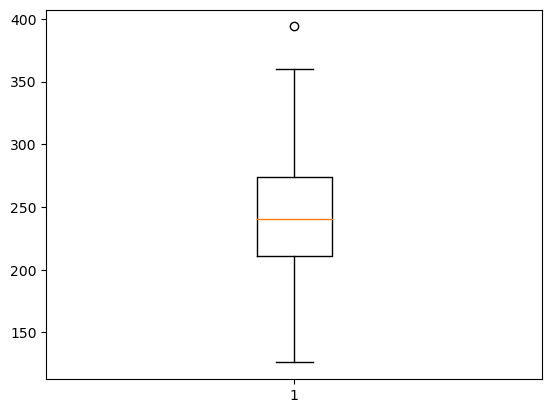

In [25]:
plt.boxplot(df.chol);

In [26]:
handleOutliers('chol', df, 'iqr')

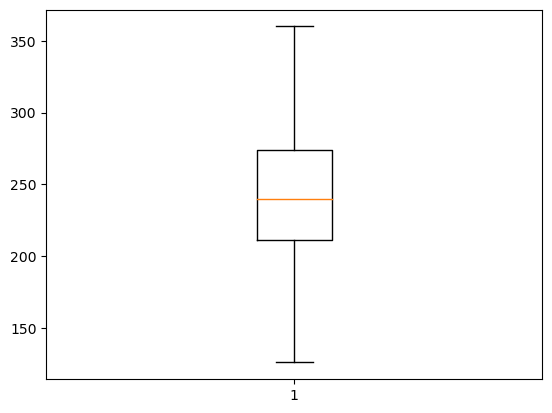

In [27]:
plt.boxplot(df.chol);

Pheeew, it took us a while to get rid of outliers in the chol variable. Let's check for outliers in the other quantitative variables.

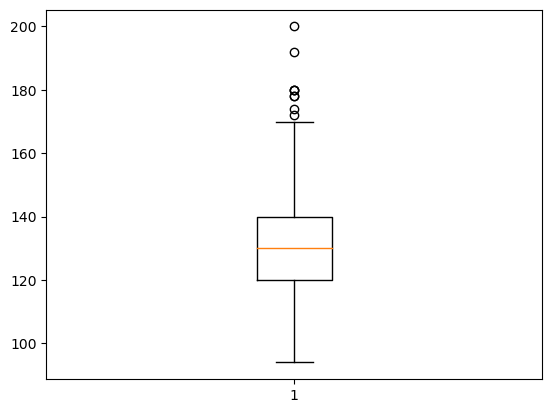

In [28]:
plt.boxplot(df.trestbps);

In [29]:
handleOutliers('trestbps', df, 'iqr', 0.05)

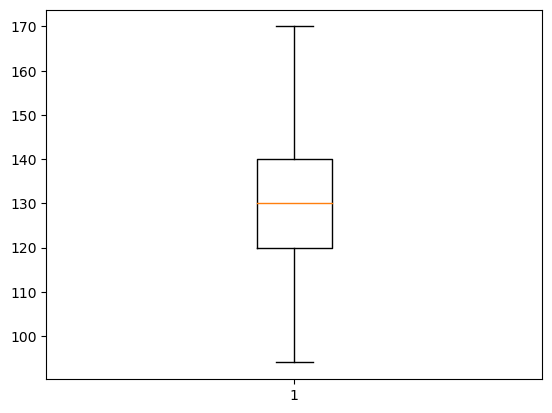

In [30]:
plt.boxplot(df.trestbps);

In [31]:
len(df)

288

### That is enough outlier handling. Time to encode our qualitative features so we can feed our data to the machine learning algorithms.

let's start by checking out what kind of qualitative features we have in our hands. Are they nominal or ordinal?

we have a few qualitative features :

**Nominal Features** : 
- sex (male/female)
- cp (chest pain type)
- restecg (resting electrocardiographic results)
- exang (exercise induced angina)
- fbs: (fasting blood sugar)
- slope (the slope of the peak exercise ST segment)
- thal (thalassemia)
- target (heart disease or not)

**Ordinal Features** : 
- ca (number of major vessels colored by fluoroscopy)

In [32]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [33]:
df.thal.unique()

array(['fixed', 'normal', 'reversible', '1', '2'], dtype=object)

In [34]:
df[df.thal == '1']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
243,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0


In [35]:
df[df.thal == '2']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
248,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [36]:
df = df[(df.thal != '1') & (df.thal != '2')]

In [37]:
df.thal.unique()

array(['fixed', 'normal', 'reversible'], dtype=object)

The values '1' and '2' must have been inserted by mistake in the thal column as it doesn't have any meaning and have only appeared once in the dataset. We resorted to deleting the two rows containing these values.

**Let's encode now our data!(and split it)**

In [38]:
df["oldpeak"]

0      2.3
1      1.5
2      2.6
3      3.5
4      1.4
      ... 
292    1.2
293    0.0
294    3.0
295    2.8
296    0.0
Name: oldpeak, Length: 286, dtype: float64

In [39]:
# Your code for encoding
X = df.drop("target", axis=1)
y = df.target

nominal_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
#ordinal_features = ["ca"]

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())  
])

encoder = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_features)
    ], remainder='passthrough'
)

# Fit the encoder first
encoded_X = encoder.fit_transform(X)

# Retrieve column names after encoding


encoded_X = pd.DataFrame(encoded_X)
encoded_X

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,63.0,145.0,233.0,150.0,2.3
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,67.0,160.0,286.0,108.0,1.5
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,67.0,120.0,229.0,129.0,2.6
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,37.0,130.0,250.0,187.0,3.5
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,41.0,130.0,204.0,172.0,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,56.0,125.0,249.0,144.0,1.2
282,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,52.0,118.0,186.0,190.0,0.0
283,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,43.0,132.0,341.0,136.0,3.0
284,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,65.0,135.0,254.0,127.0,2.8


(30.5, -0.5)

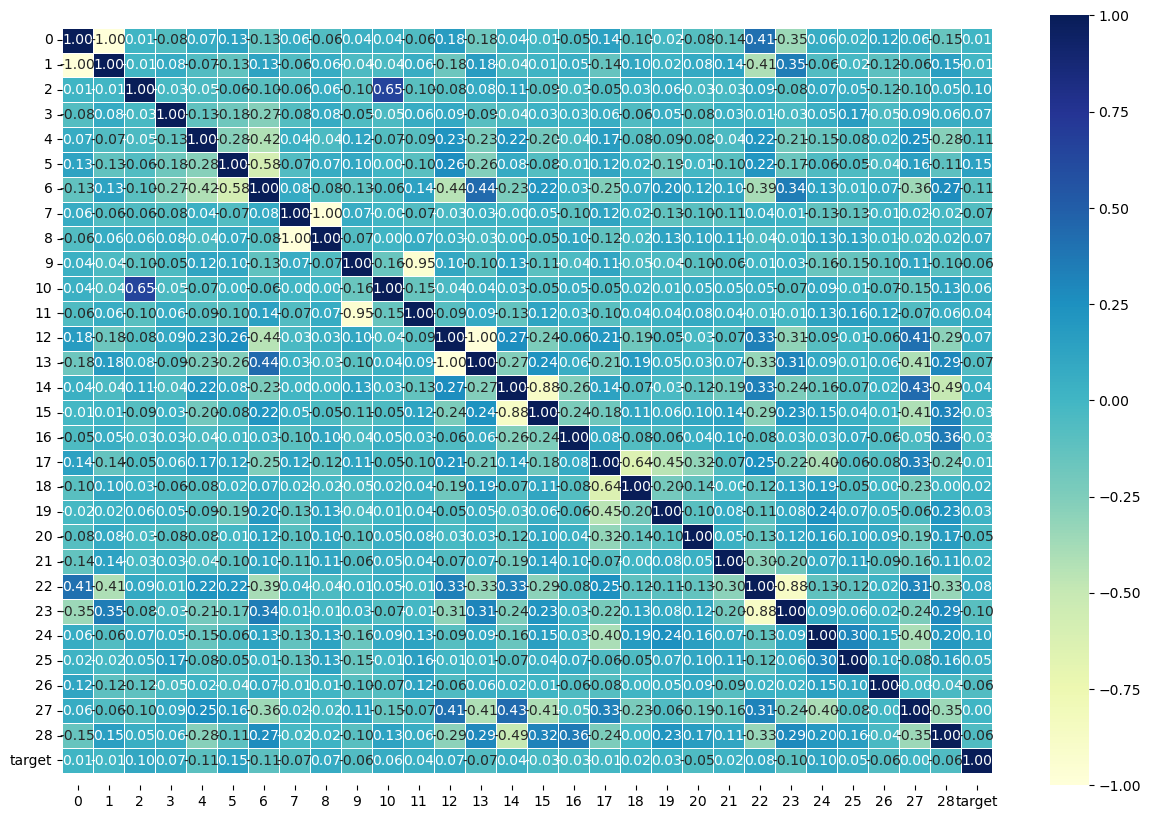

In [40]:
encoded_df = pd.DataFrame(encoded_X)
encoded_df["target"] = df.target

corr_matrix = encoded_df.corr()

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [41]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2)

clf = svm.SVC(kernel='linear', C=1)

cv = KFold(n_splits=5, shuffle=True)

scoring_metrics = ['accuracy', 'recall', 'precision', 'f1']

print(f"{clf.__class__.__name__} Cross-Validation Metrics: ")
for metric in scoring_metrics:
    print(f"{metric.capitalize()}: {np.mean(cross_val_score(clf, encoded_X, y, cv=cv, scoring=metric))}")



SVC Cross-Validation Metrics: 
Accuracy: 0.8496067755595886
Recall: 0.7401619433198381
Precision: 0.7031440781440781
F1: 0.7262037759400842


In [42]:
np.random.seed(42)

classifiers = [AdaBoostClassifier(),
    RandomForestClassifier(),
    LogisticRegression(max_iter=1000),
    GradientBoostingClassifier(),
    RidgeClassifier()
]

num_splits = 5

cv = KFold(n_splits=num_splits, shuffle=True, random_state=42)

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

for clf in classifiers:
    scores = {}
    # Perform cross-validation for each metric
    for metric in scoring_metrics:
        score = cross_val_score(clf, encoded_X, y, cv=cv, scoring=metric)
        scores[metric] = np.mean(score)

    # Print the average scores
    print(f"{clf.__class__.__name__} Cross-Validation Metrics:")
    for metric in scoring_metrics:
        print(f"  {metric.capitalize()}: {scores[metric]:.4f}")
    print("\n")

AdaBoostClassifier Cross-Validation Metrics:
  Accuracy: 0.7972
  Precision: 0.6653
  Recall: 0.5249
  F1: 0.5709


RandomForestClassifier Cross-Validation Metrics:
  Accuracy: 0.8183
  Precision: 0.7284
  Recall: 0.6315
  F1: 0.6446


LogisticRegression Cross-Validation Metrics:
  Accuracy: 0.8217
  Precision: 0.7076
  Recall: 0.6341
  F1: 0.6523


GradientBoostingClassifier Cross-Validation Metrics:
  Accuracy: 0.8146
  Precision: 0.6789
  Recall: 0.5900
  F1: 0.6312


RidgeClassifier Cross-Validation Metrics:
  Accuracy: 0.8288
  Precision: 0.7095
  Recall: 0.6674
  F1: 0.6754




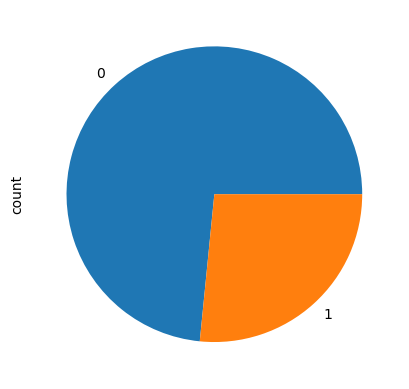

In [43]:
df.target.value_counts().plot.pie();

the reason why the recall and precision are low is because our dataset is imbalanced. We have at our hands 210 rows in which the target variable is 0 and 76 rows where the target variable is 1. 

So far the base LogisticRegression Model is the best performing out of the rest of the classifiers.
These results are not satisfying for our use case.
What we will try to do now:
- **resample the data**
- **Hyperparamter tuning**
- **get more data if possible**
- **Feature selection**
- **re-preprocess our data**

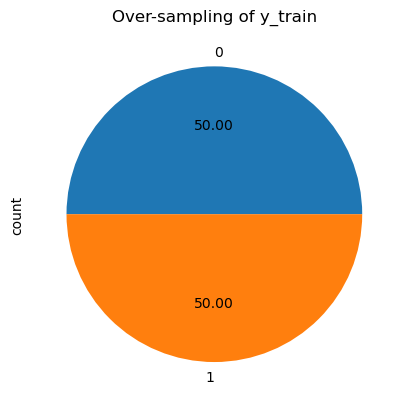

In [44]:
from imblearn.over_sampling import SMOTE

ros = SMOTE(sampling_strategy=1)
X_train_resampled , y_train_resampled = ros.fit_resample(X_train, y_train)

ax = y_train_resampled.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling of y_train")

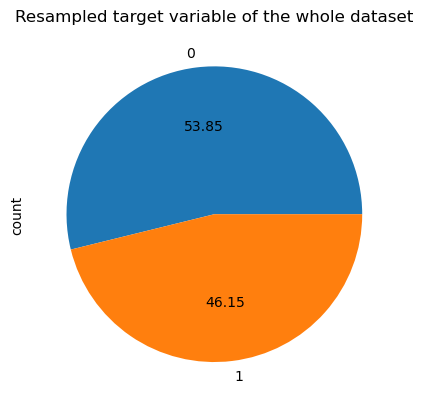

In [45]:
df_train = pd.DataFrame(X_train_resampled)

df_train["target"] = y_train_resampled


df_test = pd.DataFrame(X_test)

df_test = df_test.reset_index(drop=True)

y_test = y_test.reset_index(drop=True)

df_test["target"] = y_test

df_test.reset_index(drop=True)

df_resampled = pd.concat([df_train,df_test], axis=0)

ax = df_resampled.target.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Resampled target variable of the whole dataset")



In [46]:
X_res = df_resampled.drop("target", axis=1)
X_res = X_res.astype(np.float32)
y_res = df_resampled.target

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)



In [47]:
def evaluate_preds(y_true: np.array, 
                   y_preds: np.array) -> dict:
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.

    Returns several metrics in the form of a dictionary.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2), 
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Accuracy: {accuracy * 100:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

In [48]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

y_preds = clf.predict(X_test)

evaluate_preds(y_test, y_preds)

Accuracy: 84.62
Precision: 0.83
Recall: 0.88
F1 score: 0.85


{'accuracy': 0.85, 'precision': 0.83, 'recall': 0.88, 'f1': 0.85}

In [49]:
np.random.seed(42)

classifiers = [AdaBoostClassifier(),
    RandomForestClassifier(n_estimators=100),
    LogisticRegression(max_iter=10000),
    GradientBoostingClassifier(),
    RidgeClassifier()
]

num_splits = 5

cv = KFold(n_splits=num_splits, shuffle=True, random_state=42)

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

for clf in classifiers:
    # Print the average scores
    print(f"{clf.__class__.__name__} Metrics:")
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    evaluate_preds(y_test, y_preds)
    print("\n")

AdaBoostClassifier Metrics:
Accuracy: 87.18
Precision: 0.88
Recall: 0.88
F1 score: 0.88


RandomForestClassifier Metrics:
Accuracy: 87.18
Precision: 0.86
Recall: 0.90
F1 score: 0.88


LogisticRegression Metrics:
Accuracy: 87.18
Precision: 0.89
Recall: 0.85
F1 score: 0.87


GradientBoostingClassifier Metrics:
Accuracy: 88.46
Precision: 0.88
Recall: 0.90
F1 score: 0.89


RidgeClassifier Metrics:
Accuracy: 83.33
Precision: 0.81
Recall: 0.88
F1 score: 0.84




After resampling the data, the models are performing better and are not biased like they were before.
We used **SMOTE** resampling method that creates synthetic data, it prevents overfitting because it doesn't use original examples!
let's build on top of the RandomForestClassifier and LogisticRegression models and try to make them better in predicting the likelyhood of having a heart disease.

## Hyperparameter tuning using RandomizedSearchCV and GridSearchCV

In [50]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Create a hyperparameter grid for svm
svm_grid = {'C': [0.1, 1, 10, 100, 1000],  
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
            'kernel': ['rbf']}
# Create a hyperparameter grid for AdaBoostClassifier
ab_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }

In [51]:
np.random.seed(42)

rs_svm = RandomizedSearchCV(svm.SVC(),
                                param_distributions=svm_grid,
                                cv=5,
                                n_iter=30,
                                verbose=True)

rs_svm.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\imoua\ML Projects\heart-disease-project\env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 25 is smaller than n_iter=30. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=30,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   verbose=True)

In [52]:
rs_svm.best_params_

{'kernel': 'rbf', 'gamma': 0.0001, 'C': 1000}

In [53]:
y_preds = rs_svm.predict(X_test)
evaluate_preds(y_test, y_preds)

Accuracy: 85.90
Precision: 0.82
Recall: 0.93
F1 score: 0.87


{'accuracy': 0.86, 'precision': 0.82, 'recall': 0.92, 'f1': 0.87}

In [54]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [55]:
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [56]:
y_preds = rs_rf.predict(X_test)
evaluate_preds(y_test,y_preds)

Accuracy: 87.18
Precision: 0.86
Recall: 0.90
F1 score: 0.88


{'accuracy': 0.87, 'precision': 0.86, 'recall': 0.9, 'f1': 0.88}

In [57]:
from sklearn import svm
np.random.seed(42)
svm_model = svm.SVC(kernel='rbf', gamma= 0.0001, C=100)
svm_model.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=510,
                            min_samples_split=18,
                            min_samples_leaf=19,
                            max_depth=5)

rf.fit(X_train, y_train)

classifiers = [svm_model, rf]

for clf in classifiers:
    print(f"{clf.__class__.__name__} Cross-Validation Metrics:")
    y_preds = clf.predict(X_test)
    evaluate_preds(y_test, y_preds)
    print("\n")

SVC Cross-Validation Metrics:
Accuracy: 83.33
Precision: 0.81
Recall: 0.88
F1 score: 0.84


RandomForestClassifier Cross-Validation Metrics:
Accuracy: 85.90
Precision: 0.85
Recall: 0.88
F1 score: 0.86




## Saving the best model 

In [58]:
pickle.dump(rf, open("../models/heart_disease_classifier.pkl", "wb"))

In [59]:
loaded_model = pickle.load(open("../models/heart_disease_classifier.pkl","rb"))


print(f"{loaded_model.__class__.__name__} Cross-Validation Metrics: ")
for metric in scores:
    print(f"{metric.capitalize()}: {np.mean(cross_val_score(loaded_model, X_res, y_res, cv=cv, scoring=metric))}")



RandomForestClassifier Cross-Validation Metrics: 
Accuracy: 0.8846153846153845
Precision: 0.8756937799043062
Recall: 0.8909913209041116
F1: 0.8788593110238583


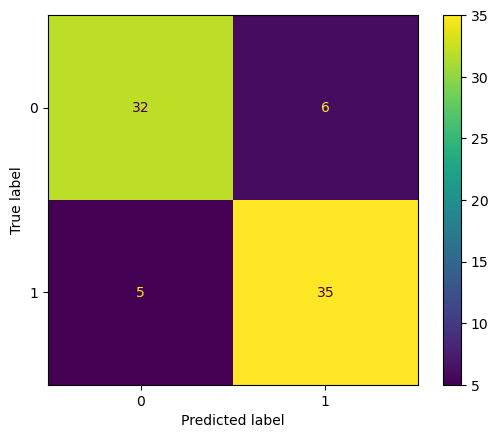

In [65]:
y_preds = loaded_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

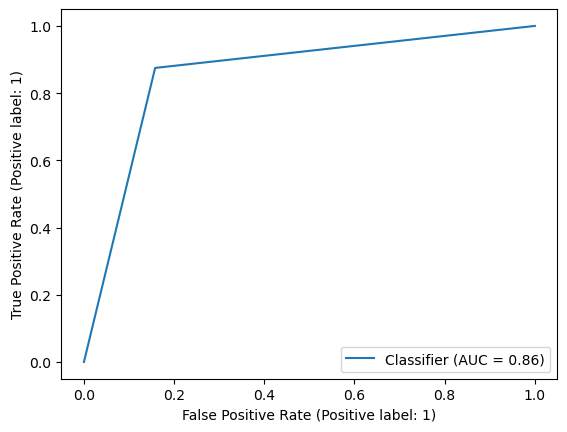

In [69]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_true)


In [67]:
from sklearn.metrics import roc_auc_score

roc_auc_score_value = roc_auc_score(y_test, y_preds)
roc_auc_score_value

0.8585526315789473

## Converting the model to ONNX format

In [61]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx
# Convert scikit-learn model to ONNX format
initial_type = [('float_input', FloatTensorType([None, X_test.shape[1]]))]
onnx_model = convert_sklearn(rf, initial_types=initial_type)

# Save the ONNX model to a file
onnx.save_model(onnx_model, '../models/heart_disease_classifier.onnx')


In [62]:
import onnxruntime
import onnx
import numpy as np

# Load the ONNX model
onnx_model = onnx.load_model('../models/heart_disease_classifier.onnx')

# Create an ONNX Runtime inference session
session = onnxruntime.InferenceSession(onnx_model.SerializeToString())

# Prepare the input data (X_test)
input_data = np.array(X_test, dtype=np.float32)

# Run the inference
output = session.run(None, {'float_input': input_data})

# The 'output' variable now contains the model predictions
predictions = (output[0] > 0.5).astype(int)  # Adjust as needed based on your model's output

predictions

evaluate_preds(y_test, predictions)

Accuracy: 85.90
Precision: 0.85
Recall: 0.88
F1 score: 0.86


{'accuracy': 0.86, 'precision': 0.85, 'recall': 0.88, 'f1': 0.86}